# Multilayer Perceptrons

Deeper models have higher representational power

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from d2l import torch as d2l

Linear models assume *monocity* and *linearity* in the solutions.

An increase of the values of the features will only increase or only decrease **linearly** the output result

**In reality, these assumptions rarely hold**

**Examples**: Predict death based on a person body temperature -> not monotonic and not linear

A loan based on someone's salary -> not linear.

Image classification -> not monotonic and not linear.

Having hidden layers give better representation power as it allows non-linear composition of features

<center>
    <img src='images/mlp.svg' width='60%'/>
    <p>Source: <a href='d2l.ai'>d2l.ai</a></p>
</center>

But only adding hidden layer representation is not enough. Why?

Composition of linear transformations is a linear transformation.

**Meaning**: If you don't have non-linearities, you could have 1000s of hidden layers, you can find a neural network without a hidden layer that performs the **same transformation**

These non-linearities are called **activation** functions

They apply nonlinear transformation after each layer.

In theory, a Neural Network with only one hidden layer and an arbitrary number of neurons in this hidden layer can approximate any function. In practice, it is often more efficient to have multiple hidden layers than one very wide one.

## Tanh

$$\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

<center>
<img src='images/output_mlp_76f463_66_0.svg' width='60%'/>
</center>

Around 0, it is almost linear while being very non-linear outside $[-1,1]$

In [2]:
tanh = torch.nn.Tanh()
x = torch.rand((3, 5)) - 0.5
y = tanh(x)
x, y

(tensor([[ 0.0176,  0.3103,  0.0237, -0.0722, -0.0421],
         [ 0.0163,  0.2237,  0.0236,  0.3226,  0.2867],
         [ 0.4346,  0.2245,  0.4966, -0.2780, -0.0017]]),
 tensor([[ 0.0176,  0.3007,  0.0237, -0.0721, -0.0421],
         [ 0.0163,  0.2201,  0.0236,  0.3118,  0.2791],
         [ 0.4092,  0.2208,  0.4594, -0.2710, -0.0017]]))

## ReLU

$$\operatorname{ReLU}(x) = \max(x, 0).$$

<center>
<img src='images/output_mlp_76f463_18_0.svg' width='60%'/>
</center>

In [3]:
relu = torch.nn.ReLU()
x = torch.rand((3, 5)) - 0.5
y = relu(x)
x, y

(tensor([[ 0.2975, -0.0152, -0.3099,  0.1237, -0.1665],
         [-0.2781,  0.3265, -0.0653,  0.4923, -0.1796],
         [ 0.2621, -0.4126,  0.2462,  0.1963, -0.4534]]),
 tensor([[0.2975, 0.0000, 0.0000, 0.1237, 0.0000],
         [0.0000, 0.3265, 0.0000, 0.4923, 0.0000],
         [0.2621, 0.0000, 0.2462, 0.1963, 0.0000]]))

ReLU is very powerful because it's linear both on the negative and positive sides.

ReLU ends up making the Neural Network **sparse**: After applying it, a bunch of neural have 0 values. Thus the network becomes sparse. This has computation advantage (no need to consider these neurons) but theoretical ones too.

On the other hand, you may face the problem of **dead ReLU**: if too many neurons have a 0 value, they will not be updated during gradient descent (derivate of ReLU on the negative side is 0)

## Which one to use when?

### Tanh

For **small** networks (2 or fewer hidden layers, 256 or fewer units per layer), Tanh generally performs well.

If your neural network gets deeper, you might have some vanishing gradient issues.

<center>
<img src='images/output_mlp_76f463_78_0.svg' width='60%'/>
</center>

If your neural network gets wider, you might **saturate** the function.

### ReLU

For **bigger**/**wider** networks, **ReLU** is a good default.
For some applications like **GANs**, **ReLU** is not adapted due to the *dying relu* problem.

If you see that the gradient norm goes to 0 after some training steps while your model still has a high loss, you might try **Leaky ReLU**

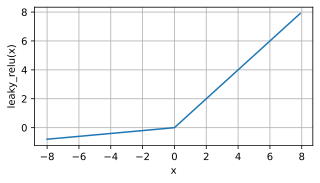

In [4]:
activation_fn = torch.nn.LeakyReLU(negative_slope=0.1) #by default negative slope is 0.01
x = torch.arange(-8.0, 8.0, 0.1)
y = activation_fn(x)
d2l.plot(x.detach(), y.detach(), 'x', 'leaky_relu(x)', figsize=(5, 2.5))

# ⚠️ Layer initialization depends on the activation function used ⚠️

## [https://pytorch.org/docs/stable/nn.init.html](https://pytorch.org/docs/stable/nn.init.html)

In [5]:
def init_my_layer(m, gain=1):
    torch.nn.init.xavier_normal_(m.weight, gain) #nn.init.calculate_gain('tanh'))
    torch.nn.init.constant_(m.bias, 0)
    return m

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.ln1 = init_my_layer(nn.Linear(1, 12), nn.init.calculate_gain('tanh'))
        self.ln2 = init_my_layer(nn.Linear(12, 12), nn.init.calculate_gain('relu'))
        self.ln3 = init_my_layer(nn.Linear(12, 1))

    def forward(self, x):
        x = self.tanh(self.ln1(x))
        x = self.relu(self.ln2(x))
        return self.ln3(x)
    
my_mlp = nn.Sequential(
    init_my_layer(nn.Linear(1, 12), nn.init.calculate_gain('tanh')),
    nn.Tanh(),
    init_my_layer(nn.Linear(12, 12), nn.init.calculate_gain('relu')),
    nn.ReLU(),
    init_my_layer(nn.Linear(12, 1))
)

In [6]:
batch = torch.rand((32, 1))
#my_mlp = MyModel()
my_mlp(batch)

tensor([[0.6666],
        [0.9551],
        [1.0598],
        [0.5018],
        [0.8357],
        [0.4161],
        [0.9848],
        [0.0087],
        [0.6571],
        [0.5151],
        [1.0636],
        [0.7154],
        [1.0225],
        [0.6906],
        [0.3419],
        [0.9097],
        [0.6575],
        [0.8305],
        [1.1907],
        [0.5211],
        [0.4154],
        [1.0699],
        [0.0518],
        [1.1982],
        [0.7269],
        [0.5184],
        [0.9868],
        [0.6804],
        [0.6578],
        [0.9191],
        [0.0631],
        [1.0764]], grad_fn=<AddmmBackward0>)

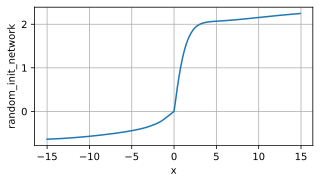

In [7]:
x = torch.arange(-15.0, 15.0, 0.1).reshape(-1, 1)
y = my_mlp(x).reshape(-1)
x = x.reshape(-1)
d2l.plot(x.detach(), y.detach(), 'x', 'random_init_network', figsize=(5, 2.5))

The output is clearly not linear